## FINAL PROJECT
Frederik Kallestrup Mastratis (qln174)  
Dongyu Liu (dlf327)  
Shamim Tariq Akram (zmx145)  
Celina Aurora Nguyen (szf345)  

Group 21

## PACKAGES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

from cleantext import clean
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model, metrics, naive_bayes, svm

from keras.models import Sequential

import psycopg2

ModuleNotFoundError: No module named 'tensorflow'

## TEXT CLEANER

In [37]:
DATE = '3[01]|[12][0-9]|0?[1-9]'
DATE_SUFFIXES = 'st|th|rd|nd'
DAY = '(mon|tues|thurs|fri|sun)(day)?|wed(nesday)?|sat(urday)?'
YEAR = '([12][0-9])?[0-9]{2}'
MONTHS = 'jan\.?(uary)?|feb\.?(ruary)?|mar\.?(ch)?|apr\.?(il)?|may|jun\.?(e)?|jul\.?(y)?|aug\.?(ust)?|sep\.?(tember)?|oct\.?(ober)?|nov\.?(ember)?|dec\.?(ember)?'

# format: pretty much all digit formats DD/MM/YY etc.
fd1 = '((%s)\s,?)?\d{1,4}[\\/-]\d{1,2}[\\/-]\d{1,4}' % (DAY)
# format: DD-DD MON (YYYY)
fd2 = '((%s)\s,?)?(%s)(%s)?(\s?-\s?(%s))?\s(%s)(\s?,?\s(%s))?' % (DAY, DATE, DATE_SUFFIXES, DATE, MONTHS, YEAR)
# format: MON DD-DD (YYYY)
fd3 = '((%s)\s,?)?(%s)\s(%s)(%s)?(\s?-\s?(%s))?(\s?,?\s(%s))?' % (DAY, MONTHS, DATE, DATE_SUFFIXES, DATE, YEAR)
# format: MON YYYY
fd4 = '(%s)\s(%s)?' % (MONTHS, YEAR)

DATES_REGEX = re.compile(r"(%s)|(%s)|(%s)|(%s)" % (fd1, fd2, fd3, fd4))

def clean_text(txt):
    txt = txt.lower()

    txt = re.sub(r"\s+", " ", txt)
    regex = {" EMAIL " : r"\w+@\w+(\.[a-z]{2})?\.[a-z]{2,3}",
        " URL " : r"([a-z\d]+://)?[a-z]+[a-z\d]*(\.[a-z\d\-\._~]+)+(/[a-z\d\-\._~]*|(\?[a-z\d\-\._~]+=[a-z\d\-\._~]+))*",
        " DATE " : DATES_REGEX,
        " NUM " : r"[+-]?((\d+(,|\.))*\d+)"}

    for k in regex.keys():
      txt = re.sub(regex[k], k, txt)

    txt = re.sub(r"/", "", txt)

    # Extra cleaning with cleantext library
    txt = clean(txt,
      lower=False,
      normalize_whitespace=True,
      no_line_breaks=True,
      strip_lines=True,
      no_numbers=True, replace_with_number= ' NUM ',
      no_urls=True, replace_with_url=' URL ',
      no_emails=True, replace_with_email=' EMAIL ',
      no_punct=True, replace_with_punct=''
    )

    tokens = word_tokenize(txt)
    prepostfix = lambda t: "<"+t+">" if t.isupper() else t
    tokens = list(map(prepostfix, tokens))

    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

    stemmer = SnowballStemmer(language='english')
    tokens = [stemmer.stem(w) if w[0] != '<' else w for w in tokens]
    
    return tokens

In [38]:
##lemmatize
def tokenize_mood(txt):
  tokens = nltk.sent_tokenize(txt)
  prepostfix = lambda t: "<"+t+">" if t.isupper() else t
  return map(lambda sentence: map(prepostfix, sentence), tokens)

def mood_mapper(mood):
  if mood.startswith('J'):
        return wordnet.ADJ
  elif mood.startswith('V'):
        return wordnet.VERB
  elif mood.startswith('N'):
        return wordnet.NOUN
  elif mood.startswith('R'):
        return wordnet.ADV
  else:          
        return None

def Lemm(tokenss):
  lemmatize = WordNetLemmatizer().lemmatize
  stop_words = set(stopwords.words('english'))
  tss = map(lambda ts: map(lambda t: (t[0], mood_mapper(t[1]))), tokenss)
  lemmatized = []
  for ts in tss:
    for word, mood in ts:
      w = word if mood is None else lemmatize(word, mood)
      if not w in stop_words: 
        lemmatized.append(w)
  return lemmatized

In [39]:
df_test = pd.read_csv("https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv", delimiter=",")

df_test = df_test.dropna(subset =["type"])

df_content = df_test["content"]
df_tokens = df_content.apply(clean_text)

df_test["tokens"] = df_tokens
df_cleaned = df_tokens.apply(lambda x: ' '.join(x))
df_test["cleaned_content"] = df_cleaned

df_cleaned.to_csv('testclean.csv')

## Observations

1. **Length by article type (*type_token_relation*):** 
This boxplot gives the distribution of the length of the articles in tokens within article types. Taking into consideration that the supermajority of articles types are undersamples in the data set (<6) (observation 2) this observation does not make it seem likely that there is a useful correlation between length and type.  
2. **URL token frequency by article type (*type_URLfreq_relation*):**
This boxplot gives the distribution of the frequency of the URL token within article type. It shows that many types are undersampled. This motivated us to look at the criteria for the types in the FakeNewsCorpus; aritcle types are mutually exclusive, but their semantics are not. This begs the question how FakeNews corpus decides when multiple types are appropriate - it seems that they have som rank-order for which type takes precedens, though as observation 4 shows this cannot be concluded.  
3. **Distribution of types (*type_distribution*):**
This barplot shows the distribution of types. From it we can conclude that the data(sub)set has an exponential drop-off in how populated each types is. Since we only have about 250 articles this means that the less populated types are very undersampled.
4. **Distribution of types within a domain(*domain_type_relation*)**
Most interestingly this oberservation shows us that each domain only have one type associated with them. This means that we have to be careful about what our model is actually checking; it could be that it is only checking the domain (through inference by the structure of the tokens) and then guesses by the type associated with the domain. It also shows that the datasubset have very few articles associated for each domain (<3).

In [40]:
# Function which returns list of token counts [URL, NUM, DATA, EMAIL, ALL_tokens]
def count_tokens(tokens):
    meta_tokens  = ["<URL>", "<NUM>", "<DATE>", "<EMAIL>"]
    meta_counts = [0, 0, 0, 0]
    for token in tokens:
      if token in meta_tokens:
        i = meta_tokens.index(token)
        meta_counts[i] += 1
    token_count = len(tokens)
    return [token_count] + meta_counts


# Observation 1 - relationship between type and tokencount (length of article)
def type_token_relation(df):
    counts = df["tokens"].apply(count_tokens)
    tokens = counts.apply(lambda xs: xs[0])
    tokens = tokens.rename("token_count")
    df_temp = pd.concat([df["type"], tokens], axis=1)

    df_ret = pd.DataFrame(index = df.index)
    types = df_temp["type"].unique()
    for t in types:
        df_ret[t] = df_temp[df_temp["type"] == t]["token_count"]
        pd.concat([df_ret, df_ret[t]], axis=1, ignore_index = True) 

    df_ret.boxplot(rot=45)

    return df_ret.mean(axis=0)

# Observation 2 - relationship between type and URL frequency
def type_URLfreq_relation(df):
    counts = df["tokens"].apply(count_tokens)
    url_freq = counts.apply(lambda xs: xs[1]/xs[0])
    url_freq = url_freq.rename("url_freq")
    df_temp = pd.concat([df["type"], url_freq], axis=1)

    df_ret = pd.DataFrame(index = df.index)
    types = df_temp["type"].unique()
    for t in types:
        df_ret[t] = df_temp[df_temp["type"] == t]["url_freq"]
        pd.concat([df_ret, df_ret[t]], axis=1, ignore_index = True) 

    df_ret.boxplot(rot=45)

    return df_ret.mean(axis=0)

# Observation 3 - type distribution of dataset
def type_distribution(df):
    df['type'].value_counts().plot.bar()
    return df['type'].value_counts()

# Observation 4 - types of article each domain publishes
def domain_type_relation(df):
    domains = df["domain"].unique()
    types = []
    for domain in domains:
        types.append(df[df["domain"] == domain]["type"].value_counts().to_dict())
    idx = sorted(range(len(types)), key=lambda i: list(types[i].items())[0][1])
    return list(map(lambda i: (domains[i], types[i]), reversed(idx)))

unreliable     181.666667
fake           377.606452
clickbait      163.000000
conspiracy     461.483871
reliable       256.666667
bias           253.833333
hate            32.000000
junksci        219.166667
political      368.260870
unknown       1226.166667
dtype: float64

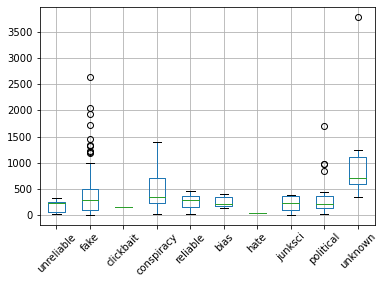

In [41]:
type_token_relation(df_test)

unreliable    0.016894
fake          0.011174
clickbait     0.000000
conspiracy    0.006394
reliable      0.002193
bias          0.012063
hate          0.000000
junksci       0.024873
political     0.006453
unknown       0.003593
dtype: float64

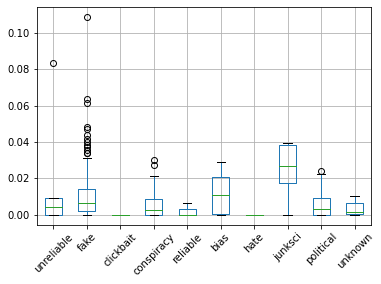

In [42]:
type_URLfreq_relation(df_test)

fake          155
conspiracy     31
political      23
unreliable      6
bias            6
junksci         6
unknown         6
reliable        3
clickbait       1
hate            1
Name: type, dtype: int64

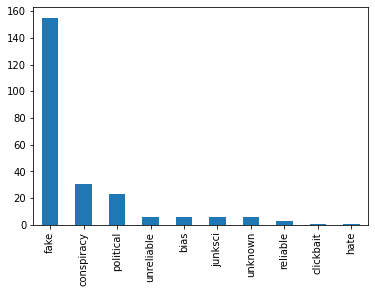

In [43]:
type_distribution(df_test)

In [44]:
domain_type_relation(df_test)

[('beforeitsnews.com', {'fake': 155}),
 ('canadafreepress.com', {'conspiracy': 24}),
 ('washingtonexaminer.com', {'political': 17}),
 ('awarenessact.com', {'conspiracy': 6}),
 ('naturalnews.com', {'junksci': 5}),
 ('strategic-culture.org', {'unknown': 4}),
 ('christianpost.com', {'reliable': 3}),
 ('city-journal.org', {'political': 2}),
 ('vdare.com', {'bias': 2}),
 ('undergroundhealth.com', {'unknown': 2}),
 ('alternet.org', {'political': 2}),
 ('awm.com', {'unreliable': 2}),
 ('breitbart.com', {'political': 1}),
 ('anonhq.com', {'unreliable': 1}),
 ('americanlookout.com', {'bias': 1}),
 ('washingtonsblog.com', {'bias': 1}),
 ('21stcenturywire.com', {'conspiracy': 1}),
 ('unz.com', {'bias': 1}),
 ('nationalreview.com', {'political': 1}),
 ('collectivelyconscious.net', {'junksci': 1}),
 ('breakpoint.org', {'unreliable': 1}),
 ('barenakedislam.com', {'hate': 1}),
 ('charismanews.com', {'bias': 1}),
 ('blackagendareport.com', {'unreliable': 1}),
 ('bipartisanreport.com', {'clickbait': 1}

## TRAINING

In [45]:
conn = psycopg2.connect(dbname="fakenewsdb", user="postgres", password="1234")

In [46]:
# Dataset for model

query_fnc = """
    SELECT id, type, content
    FROM fnc_article
"""

df_fncpull = pd.read_sql(query_fnc, conn)

In [47]:
df_fncpull

df_fncpull['type'].value_counts()

political     2805
unreliable    1472
bias          1337
fake          1161
conspiracy    1044
NaN            878
rumor          450
clickbait      238
junksci        167
satire         135
reliable        73
hate            41
Name: type, dtype: int64

In [48]:
type_real = ['political', 'reliable', 'clickbait']
type_fake = ['fake', 'satire', 'bias', 'conspiracy', 'junksci', 'hate']

def type_classifier(type):
    if type in type_real:
        type = 1
    elif type in type_fake:
        type = 0

    return type

In [49]:
df_fncpull = df_fncpull[df_fncpull['type'].isin(type_real + type_fake)]

df_fncpull['type'] = df_fncpull['type'].apply(type_classifier)

df_fncpull['type'].value_counts()

0    3885
1    3116
Name: type, dtype: int64

In [50]:
# df_fnccontent = df_fncpull["content"]
# df_fnctokens = df_fnccontent.apply(clean_text)

# df_fnccleaned = df_fnctokens.apply(lambda x: ' '.join(x))
# df_fncpull["content"] = df_fnccleaned

# df_fncpull.to_csv('fncpullcleaned.csv', index = False)

In [51]:
df_fncpull = pd.read_csv('fncpullcleaned.csv')

In [52]:
X_train, X_rem, y_train, y_rem = train_test_split(df_fncpull['content'], df_fncpull['type'], train_size = 0.7)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size = 0.5)

In [53]:

vectorizer = TfidfVectorizer(       
    lowercase=False, 
    ngram_range=(1,1), 
    token_pattern=r"(?u)\b\w\w+\b|<DATE>|<NUM>|<EMAIL>|<URL>"
)

vectorizer.fit(X_train)

TFIDF_Xtrain = vectorizer.transform(X_train)
TFIDF_Xtest = vectorizer.transform(X_test)
TFIDF_Xvalid = vectorizer.transform(X_valid)

len(vectorizer.get_feature_names())


58660

### Logistic Regression

In [54]:
# Baseline hyperparameter tuning Log.reg

logreg_model = linear_model.LogisticRegression()

logreg_param = [
    {'penalty' : ['l1'], 'C' : np.logspace(-4, 4, 20), 'solver' : ['liblinear']},
    {'penalty' : ['l2'], 'C' : np.logspace(-4, 4, 20), 'solver' : ['lbfgs','newton-cg','saga']}
]

lrcv_clf = GridSearchCV(logreg_model, param_grid = logreg_param, cv=3, verbose = 5, n_jobs = -1)

In [55]:
lrbase_clf = logreg_model.fit(TFIDF_Xtrain, y_train)

In [56]:
lrhyper_clf = lrcv_clf.fit(TFIDF_Xtrain, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


In [57]:
lrhyper_clf.best_estimator_

LogisticRegression(C=1.623776739188721, penalty='l1', solver='liblinear')

In [58]:
lrhyper_clf.score(TFIDF_Xtrain, y_train)

print (f'Base Accuracry: {lrbase_clf.score(TFIDF_Xtest, y_test):.3f}\nHyper Accuracy: {lrhyper_clf.score(TFIDF_Xtest, y_test):.3f}')

Base Accuracry: 0.813
Hyper Accuracy: 0.822


In [59]:
lrbase_predict_proba = lrbase_clf.predict_proba(TFIDF_Xtest)[::,1]
lrhyper_predict_proba = lrhyper_clf.predict_proba(TFIDF_Xtest)[::,1]

lrbase_fpr, lrbase_tpr, _ = metrics.roc_curve(y_test, lrbase_predict_proba)
lrhyper_fpr, lrhyper_tpr, _ = metrics.roc_curve(y_test, lrhyper_predict_proba)

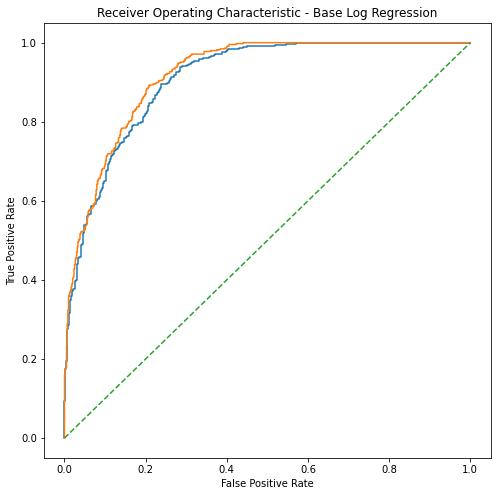

In [60]:
plt.subplots(1, figsize=(8,8))

plt.title('Receiver Operating Characteristic - Base Log Regression')
plt.plot(lrbase_fpr, lrbase_tpr)
plt.plot(lrhyper_fpr, lrhyper_tpr)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Naive Bayes

In [61]:
# Naive Bayes

nb_model = naive_bayes.MultinomialNB()

nb_param = [
    {'alpha' : [0.0, 0.01, 0.05] + np.linspace(0.1, 1, 10).tolist() + [5.0, 10.0, 100.0]}
]

nbcv_clf = GridSearchCV(nb_model, param_grid = nb_param, cv=3, verbose = 5, n_jobs = -1)

In [62]:
nbbase_clf = nb_model.fit(TFIDF_Xtrain, y_train)

In [63]:
nbhyper_clf = nbcv_clf.fit(TFIDF_Xtrain, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [64]:
nbhyper_clf.best_estimator_

MultinomialNB(alpha=0.5)

In [65]:
print (f'Base Accuracry: {nbbase_clf.score(TFIDF_Xtest, y_test):.3f}\nHyper Accuracy: {nbhyper_clf.score(TFIDF_Xtest, y_test):.3f}')

Base Accuracry: 0.803
Hyper Accuracy: 0.801


In [75]:
nbbase_predict_proba = nbbase_clf.predict_proba(TFIDF_Xtest)[::,1]
nbhyper_predict_proba = nbhyper_clf.predict_proba(TFIDF_Xtest)[::,1]

nbbase_fpr, nbbase_tpr, _ = metrics.roc_curve(y_test, nbbase_predict_proba)
nbhyper_fpr, nbhyper_tpr, _ = metrics.roc_curve(y_test, nbhyper_predict_proba)

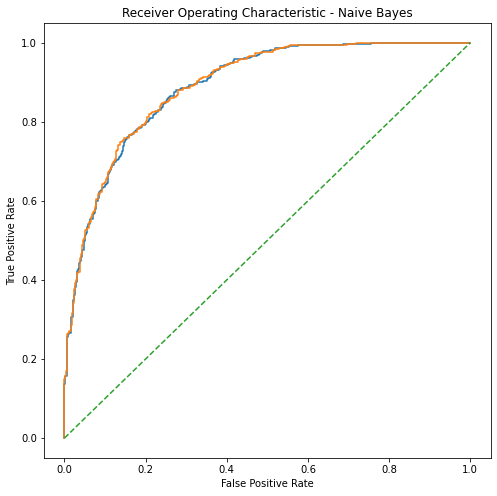

In [67]:
plt.subplots(1, figsize=(8,8))

plt.title('Receiver Operating Characteristic - Naive Bayes')
plt.plot(nbbase_fpr, nbbase_tpr)
plt.plot(nbhyper_fpr, nbhyper_tpr)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Support Vector Machine

In [77]:
svm_model = svm.SVC(probability=True)

svm_param = [
    {'kernel' : ['linear'], 'C' : [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}
]

svmcv_clf = GridSearchCV(svm_model, param_grid = svm_param, cv=3, verbose = 5, n_jobs = -1)

svm_param

[{'kernel': ['linear'], 'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}]

In [78]:
svmbase_clf = svm_model.fit(TFIDF_Xtrain, y_train)

In [80]:
svmhyper_clf = svmcv_clf.fit(TFIDF_Xtrain, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [81]:
svmhyper_clf.best_estimator_

SVC(kernel='linear', probability=True)

In [82]:
print (f'Base Accuracry: {svmbase_clf.score(TFIDF_Xtest, y_test):.3f}\nHyper Accuracy: {svmhyper_clf.score(TFIDF_Xtest, y_test):.3f}')

Base Accuracry: 0.814
Hyper Accuracy: 0.812


In [83]:
svmbase_predict_proba = svmbase_clf.predict_proba(TFIDF_Xtest)[::,1]
svmhyper_predict_proba = svmhyper_clf.predict_proba(TFIDF_Xtest)[::,1]

svmbase_fpr, svmbase_tpr, _ = metrics.roc_curve(y_test, svmbase_predict_proba)
svmhyper_fpr, svmhyper_tpr, _ = metrics.roc_curve(y_test, svmhyper_predict_proba)

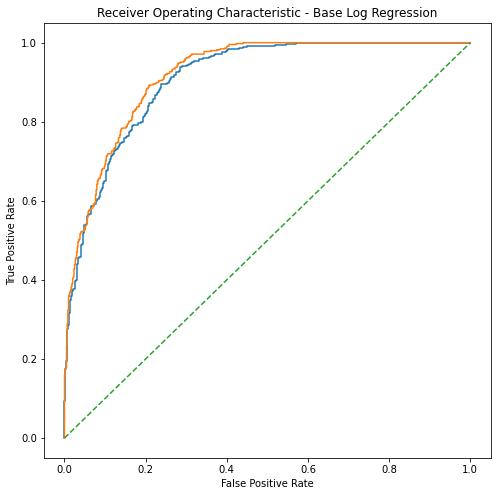

In [84]:
plt.subplots(1, figsize=(8,8))

plt.title('Receiver Operating Characteristic - Base Log Regression')
plt.plot(lrbase_fpr, lrbase_tpr)
plt.plot(lrhyper_fpr, lrhyper_tpr)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()